**Imports**

In [96]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import pearsonr, spearmanr


student_dropout_file = "STUDENT_DROPOUT.csv"

student_dropout_data = pd.read_csv(student_dropout_file, 
                                   sep=",",
                                   encoding="utf-8-sig",    #UTF-8-sig  :   All Languages
                                   #encoding="cp860",       #CP860      :   Portuguese
                                   #
                                   header=None, engine="python")


teacher_age_file = "TEACHER_AGE.csv"

teacher_age_data = pd.read_csv(teacher_age_file, sep=",",encoding="utf-8-sig", header=None, engine="python")



**STUDENT DATA EXAMPLE**

In [97]:
student_dropout_data.head()

,0,1,2,3,4,5,6,7,8
0,01. Ano,02. Nome Região (Portugal),03. Âmbito Geográfico,04. Filtro 1,05. Filtro 2,06. Filtro 3,07. Escala,08. Símbolo,09. Valor
1,1995,Portugal,NaN,Cursos Gerais,10º ano,NaN,NaN,NaN,28.6
2,1995,Portugal,NaN,Cursos Gerais,11º ano,NaN,NaN,NaN,9.6
3,1995,Portugal,NaN,Cursos Gerais,12º ano,NaN,NaN,NaN,30.1
4,1995,Portugal,NaN,Cursos Gerais,Total,NaN,NaN,NaN,21.5


**STUDENT DATA FILTER**

Keeping only the fields and the values we are interested.

In [98]:
mask = ((student_dropout_data.iloc[:, 3] == 'Total') &
    (student_dropout_data.iloc[:, 4] == 'Total'))

student_dropout_filtered = student_dropout_data.loc[mask]

student_dropout_filtered = student_dropout_filtered.iloc[:, [0, 1, 8]].copy()

student_dropout_filtered.columns = ["Year", "Region", "Student_Dropout_Value"]

student_dropout_filtered.head()


,Year,Region,Student_Dropout_Value
12,1995,Portugal,21.3
24,1996,Portugal,33.1
36,1997,Portugal,35.7
48,1998,Portugal,35.6
60,1999,Portugal,36.0


**TEACHER DATA EXAMPLE**

In [99]:
teacher_age_data.head()

,0,1,2,3,4,5,6,7,8
0,01. Ano,02. Nome Região (Portugal),03. Âmbito Geográfico,04. Filtro 1,05. Filtro 2,06. Filtro 3,07. Escala,08. Símbolo,09. Valor
1,1996,Portugal,NaN,Básico - 1º Ciclo,NaN,NaN,NaN,NaN,123.8
2,1996,Portugal,NaN,Básico - 2º Ciclo,NaN,NaN,NaN,x,NaN
3,1996,Portugal,NaN,Básico - 3º Ciclo e secundário,NaN,NaN,NaN,x,NaN
4,1996,Portugal,NaN,Educação Pré-Escolar,NaN,NaN,NaN,x,NaN


**TEACHER DATA FILTER**

Keeping only the fields and the values we are interested.

In [100]:
mask = (teacher_age_data.iloc[:, 3] == 'Básico - 3º Ciclo e secundário')

teacher_age_filtered = teacher_age_data.loc[mask]

teacher_age_filtered = teacher_age_filtered.iloc[:, [0, 1, 8]].copy()

teacher_age_filtered.columns = ["Year", "Region", "Teacher_Data_Value"]

teacher_age_filtered.head()

,Year,Region,Teacher_Data_Value
3,1996,Portugal,NaN
7,1997,Portugal,NaN
11,1998,Portugal,NaN
15,1999,Portugal,NaN
19,2000,Portugal,34.8


**MERGE**

Merging datasets focusing on Year and Region. Outer mergin to make sure we aren't losing any data.

In [101]:
merged = pd.merge(
    student_dropout_filtered,
    teacher_age_filtered,
    on=["Year", "Region"],
    how='outer'
)

merged.to_csv("merged_dataset.csv", index=False, sep=",", encoding="utf-8-sig")

In [102]:
merged.head()

,Year,Region,Student_Dropout_Value,Teacher_Data_Value
0,1995,Portugal,21.3,NaN
1,1996,Portugal,33.1,NaN
2,1997,Portugal,35.7,NaN
3,1998,Portugal,35.6,NaN
4,1999,Portugal,36.0,NaN


# IQR Outliner and Missing Values Cleanup

Cleaning Outliers by finding them with IQR technique. 


**Missing Values Cleanup:**

Drop rows where both Student_Dropout_Value and Teacher_Data_Value are missing

**IQR Cleanup:**

Cleaning by adressing setting quartiles at %25 and %75 of the set.

In [103]:
df = pd.read_csv("merged_dataset.csv")


df_cleaned = df.dropna(subset=['Student_Dropout_Value', 'Teacher_Data_Value'], how='all')


print("Rows with all missing statistical values removed.")
print("Cleaned dataset saved as 'cleaned_strict_dataset.csv'")

def remove_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return dataframe[(dataframe[column] >= lower) & (dataframe[column] <= upper)]


df_cleaned = remove_outliers_iqr(df_cleaned, 'Student_Dropout_Value')
df_cleaned = remove_outliers_iqr(df_cleaned, 'Teacher_Data_Value')


df_cleaned.to_csv("cleaned_dataset.csv", index=False)
print("Cleaned dataset saved as cleaned_dataset.csv")

Rows with all missing statistical values removed.
Cleaned dataset saved as 'cleaned_strict_dataset.csv'
Cleaned dataset saved as cleaned_dataset.csv


# Min-Max Normalization

In [104]:
df = pd.read_csv("cleaned_dataset.csv")

columns_to_normalize = ['Student_Dropout_Value', 'Teacher_Data_Value']

scaler = MinMaxScaler()

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df.to_csv("normalized_dataset.csv", index=False)

# Visualization

Before Analysis and K means and  we are visualizing data with scatter plot to see how it looks.

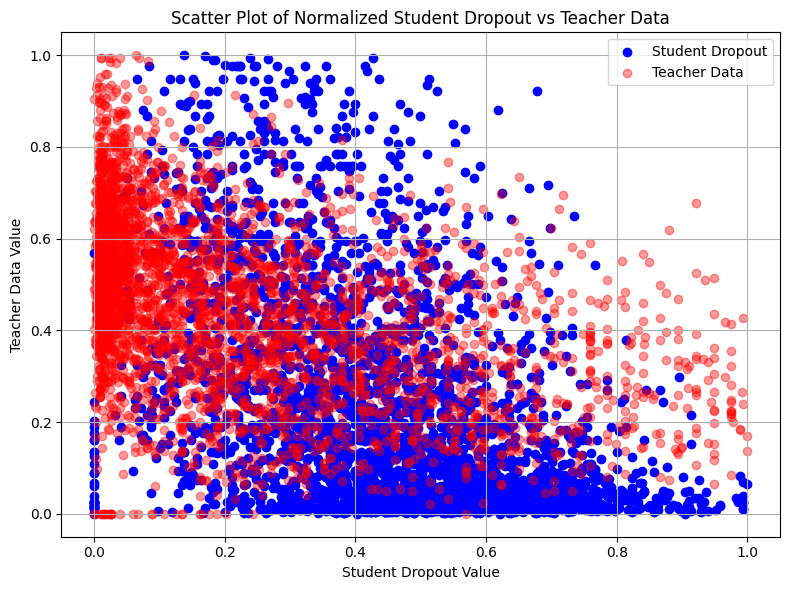

In [105]:
df = pd.read_csv("normalized_dataset.csv")

plt.figure(figsize=(8, 6))

plt.scatter(df['Student_Dropout_Value'], df['Teacher_Data_Value'], color='blue', label='Student Dropout')

plt.scatter(df['Teacher_Data_Value'], df['Student_Dropout_Value'], color='red', alpha=0.4, label='Teacher Data')

plt.title('Scatter Plot of Normalized Student Dropout vs Teacher Data')
plt.xlabel('Student Dropout Value')
plt.ylabel('Teacher Data Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Several Analysis

**Correlation Analysis**
Results show this pattern shows that as teacher values increase the dropout rate decreases.
The relationship isn’t perfectly linear but has a strong downward trend.


Maybe more stable or experienced ( relating with age of the teachers) teaching environments correlate with reduced dropout rates.

📉 Pearson Correlation: -0.4468718043578249
📊 Pearson p-value: 4.1005442342312793e-171
📉 Spearman Correlation: -0.47498628523934855
📊 Spearman p-value: 4.27186036787979e-196


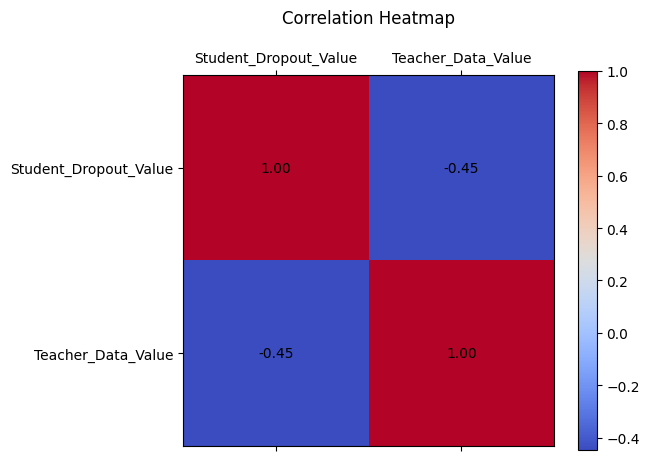

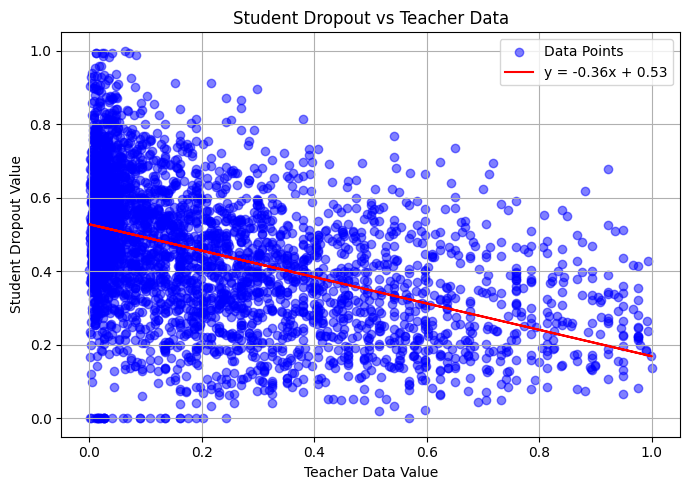

In [106]:
df = pd.read_csv("normalized_dataset.csv")

df = df.dropna(subset=['Student_Dropout_Value', 'Teacher_Data_Value'], how='all')

df_clean = df.dropna(subset=['Student_Dropout_Value', 'Teacher_Data_Value'])

pearson_corr, pearson_p = pearsonr(df_clean['Student_Dropout_Value'], df_clean['Teacher_Data_Value'])

spearman_corr, spearman_p = spearmanr(df_clean['Student_Dropout_Value'], df_clean['Teacher_Data_Value'])

print("📉 Pearson Correlation:", pearson_corr)
print("📊 Pearson p-value:", pearson_p)
print("📉 Spearman Correlation:", spearman_corr)
print("📊 Spearman p-value:", spearman_p)

correlation_matrix = df_clean[['Student_Dropout_Value', 'Teacher_Data_Value']].corr()

fig, ax = plt.subplots()
cax = ax.matshow(correlation_matrix, cmap='coolwarm')
fig.colorbar(cax)

ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns)
ax.set_yticklabels(correlation_matrix.columns)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        ax.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", va='center', ha='center')

plt.title("Correlation Heatmap", pad=20)
plt.tight_layout()
plt.show()

x = df_clean['Teacher_Data_Value']
y = df_clean['Student_Dropout_Value']

slope, intercept = pearsonr(x, y)  
m, b = np.polyfit(x, y, 1) 

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.5, label="Data Points", color='blue')
plt.plot(x, m*x + b, color='red', label=f"y = {m:.2f}x + {b:.2f}")
plt.xlabel("Teacher Data Value")
plt.ylabel("Student Dropout Value")
plt.title("Student Dropout vs Teacher Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# K-means Clustering

We used elbow method to figure what should we set for the value of k. 

**Elbow Method** 

We found the point where adding more clusters stopped giving significant benefit.

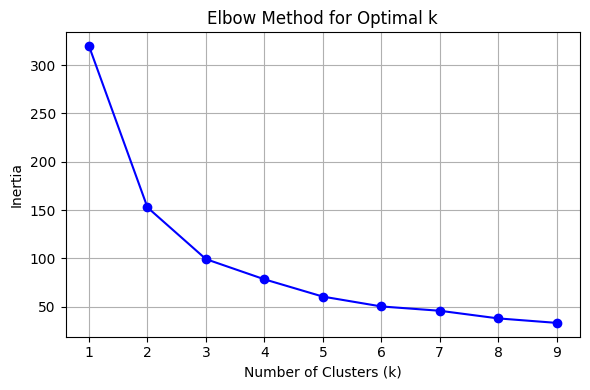

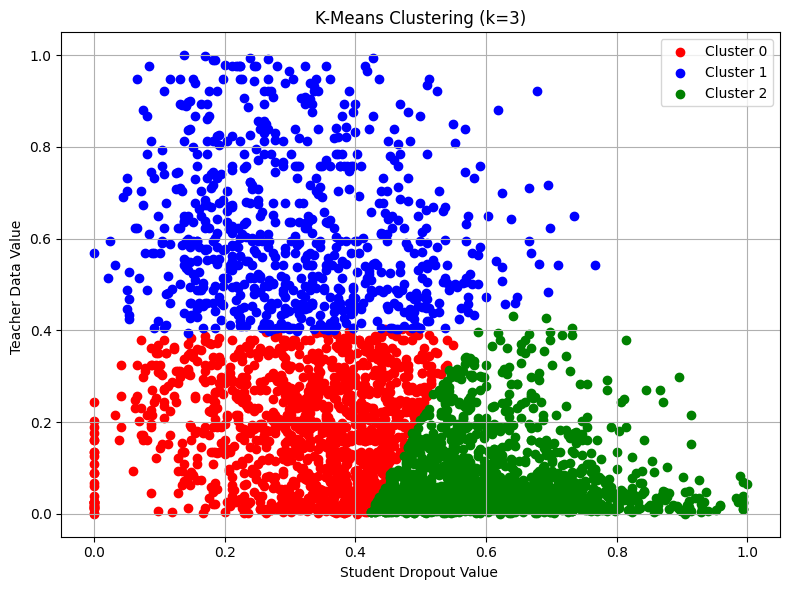

In [107]:
df = pd.read_csv("normalized_dataset.csv")


X = df[['Student_Dropout_Value', 'Teacher_Data_Value']]


inertias = []
K = range(1, 10)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertias.append(model.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()


optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)


plt.figure(figsize=(8,6))
colors = ['red', 'blue', 'green', 'purple', 'orange']

for cluster in range(optimal_k):
    clustered = df[df['Cluster'] == cluster]
    plt.scatter(clustered['Student_Dropout_Value'], clustered['Teacher_Data_Value'],
                color=colors[cluster % len(colors)], label=f'Cluster {cluster}')

plt.title(f'K-Means Clustering (k={optimal_k})')
plt.xlabel('Student Dropout Value ')
plt.ylabel('Teacher Data Value ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()